<a href="https://colab.research.google.com/github/Mathieu-Putz/Playing-with-PINNs/blob/main/PINN_PDE_1D_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import random
import matplotlib.pyplot as plt
import numpy as np  
import sympy as sy
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import statistics
import time
import csv

# Approximating 1D Diffusion with a Physics Inspired Neural Network

In this notebook, I give a simple example of a PINN (Physics Inspired Neural Network), by trying to approximate the solution to a PDE for 1D Diffusion. In particular, I will explore how we can leverage our knowledge about the partial differential equation governing diffusion to get better predictions for a given amount of data.

Let's imagine a thin tube stretching from x=0 to x=1. At t=0, a gas is spread through the tube, such that its concentration is given by the function f(x) = 1-4*(x-0.5)^2. I.e. there is a maximum at x=0.5 and at both ends of the tube the concentration is 0. Furthermore, let's impose the condition that the concentration at both ends be zero for all t. 

If we choose the right units, the diffusion will follow this PDE:

du/dt = d^2 u / dx^2

And the boundary conditions as described above are:

u(x,t=0) = f(x) = 1-4*(x-0.5)^2

u(0,t) = u(1, t) = 0

The analytical solution is known and we can use it to simulate gathering datapoints at random points. However, the exact solution is quite complicated and involves an infinite sum. I will only use the first few terms (exact number specified below). Its exact form isn't very important for our purposes, but you could of course read it off from the code in the function get_exact_solution(pts) below.

We will look at the domain where 0<=x<=1 and 0<=t<=0.3.

A traditional neural network approach might be to sample some measurement points and try to approximate them. For our purposes, let's imagine that getting those measurement points is expensive. We'd like to use as few of them as possible.

With PINNs, we can additionally use an error term that evaluates how well the neural network obeys the PDE and update gradients based on that as well as on how well it fits available data points. As demonstrated in this notebook, this allows us to get better performance for a given amount of data!

On top of that, we know the boundary conditions, without having to make any measurements. So let's use that knowledge too!

## Overview

So in this notebook we'll compare the following approaches:
- ### Vanilla
  use measurement points only
- ### Vanilla + Boundary
  use measurement points and knowledge about the boundary conditions
- ### Full PINN With Data
  use measurement points, knowledge about the boundary and knowledge about the PDE
- ### Full PINN Without Data
  use knowledge about the boundary and knowledge about the PDE, but zero measurement points

## 1. Implementation of lots of functions - feel free to skip


This section contains the definitions for lots of functions which we will use later on in the program. I recommend skipping the section and coming back to it if you want to inspect implementations of specific things. (You can collapse sections in Colab by clicking the arrow left of the title.)

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

Tesla P100-PCIE-16GB
cuda


In [3]:
# time domain from 0 to:
t_dom = 0.3
# The correct solution involves the sum of an infinite series. The following
# variable indicates how many terms of that sum we calculate:
terms = 3

In [4]:
def define_random_points(n, requires_grad=False):
  # random timepoints, ordered chronologically:
  t = np.random.rand((n))*t_dom
  t.sort()
  # random positions in the tube:
  x = np.random.rand((n))
  # first col: time; second col: position
  pts = torch.Tensor([t,x]).T
  pts = pts.to(device)
  if requires_grad:
    pts.requires_grad=True
  return pts

In [5]:
def define_boundaries(n_b_t, n_b_x):
  b_t     = torch.tensor([np.zeros(n_b_t),np.random.rand(n_b_t)]).T
  b_t, _  = torch.sort(b_t,0)
  b_x_1   = torch.tensor([t_dom*np.random.rand(n_b_x//2), np.zeros(n_b_x//2)]).T
  b_x_2   = torch.tensor([t_dom*np.random.rand(n_b_x//2), np.ones(n_b_x//2)]).T
  b_x     = torch.cat((b_x_1, b_x_2))

  b_t = b_t.to(device)
  b_x = b_x.to(device)
  return b_t, b_x

In [6]:
# f describes the concentration distribution at t=0
f = lambda y : 1 - 4*((y-0.5)**2)

In [7]:
def get_exact_solution(pts):
  x_dummy = sy.Symbol("x_dummy")
  def g(x_dummy, m):
    return f(x_dummy)*sy.sin(m*np.pi*x_dummy*1.0)
  b = lambda y ,m : 2*sy.integrate(g(y,m), (y,0,1))
  # This is the function we will try to approximate:
  h = 0
  for n in range(1,terms+1):
    B = b(x_dummy, n)
    B = float(B)
    h = h + B*torch.sin(n* np.pi * pts[:,1]) * torch.exp(- n**2 * np.pi**2* pts[:,0])
  return h

In [8]:
# Function to visualize values on a scatter plot 
def scatterplot(pts, values):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  u_graph = values.cpu().detach().numpy()
  pts_x = pts[:,1]
  pts_x = pts_x.cpu().detach().numpy()
  pts_t = pts[:,0]
  pts_t = pts_t.cpu().detach().numpy()
  # Change view angle in following line:
  ax.view_init(30, 30)

  ax.scatter3D(pts_x,  pts_t,\
             u_graph , c=u_graph)
  ax.set_xlabel("x")
  ax.set_ylabel("t")
  ax.set_zlabel("u")

In [9]:
def add_relative_noise(u):
  u = u + torch.normal(0.0,0.05*u)
  return u

In [10]:
def get_boundary_values(b_t, b_x):
  b_t_val = f(b_t[:,1])
  b_x_val = torch.zeros((b_x.size()[0]))

  #comment out to run on cpu:
  b_t_val = b_t_val.to(device)
  b_x_val = b_x_val.to(device)
  return b_t_val, b_x_val

In [11]:
def evaluate_model(n_eval):
  eval_pts = define_random_points(n_eval)

  # ground truth
  u_eval = get_exact_solution(eval_pts)

  # predictions
  pred_eval = model(eval_pts)
  pred_eval = pred_eval.squeeze()

  # return MSE
  return torch.mean((u_eval-pred_eval)**2)

In [12]:
def sketch(n_t, n_x, solution=True, angle_1=30, angle_2=30):
  # solution is a boolean determining whether we shall sketch the analytical 
  # solution (True) or the model predictions (False)

  fig = plt.figure()
  ax = plt.axes(projection='3d')
  # Make data.
  t_plot = np.linspace(0,t_dom, num=n_t)
  x_plot = np.linspace(0,1, num=n_x)
  t_plot, x_plot = np.meshgrid(t_plot, x_plot)

  # get solution or prediction
  t_plot = t_plot.reshape((n_t*n_x, ))
  x_plot = x_plot.reshape((n_t*n_x, ))
  pts = torch.Tensor([t_plot,x_plot]).T
  if solution:
    # get solution
    U_2d = get_exact_solution(pts)
  else:
    pts = pts.to(device)
    U_2d = model(pts).cpu()

  U_2d = U_2d.detach().numpy()

  t_plot = t_plot.reshape((n_t,n_x))
  x_plot = x_plot.reshape((n_t,n_x))
  U_2d = U_2d.reshape((n_t,n_x))

  if solution:
    print("This is the 'exact' solution we're trying to approximate:")
  else:
    print("This is our model's prediction:")
    
  # Plot the surface.
  ax.view_init(angle_1, angle_2)
  surf = ax.plot_surface(t_plot, x_plot, U_2d, cmap=cm.coolwarm)

  # Customize the z axis.
  ax.set_zlim(-0.1, 1.01)
  ax.zaxis.set_major_locator(LinearLocator(10))
  # A StrMethodFormatter is used automatically

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  ax.set_xlabel("t")
  ax.set_ylabel("x")
  ax.set_zlabel("u")

  plt.show()

In [13]:
def visualize_boundaries(n_t, n_x):
  
  b_t, b_x = define_boundaries(n_t, n_x)
  b_t_val, b_x_val = get_boundary_values(b_t, b_x)

  b_t = b_t.cpu().detach().numpy()
  b_x = b_x.cpu().detach().numpy()
  b_t_val = b_t_val.cpu().detach().numpy()
  b_x_val = b_x_val.cpu().detach().numpy()

  b = np.concatenate((b_t, b_x))
  b_val = np.concatenate((b_t_val,b_x_val))
  
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  
  # b__x means the x-coordinates of the total boundary b (t=0 plus x = 0)
  b__x = b[:,1]
  b__t = b[:,0]

  ax.scatter3D(b__t,  b__x,\
              b_val , c=b_val)
  ax.set_xlabel("t")
  ax.set_ylabel("x")
  ax.set_zlabel("u")

## 2. Illustrations of what we're doing

We're trying to approximate the function u(x,t) given at the very beginning. Here's what it looks like.

This is the 'exact' solution we're trying to approximate:


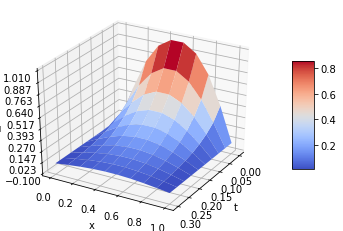

In [14]:
# The arguments of this function determine how precise the depiction is. 
# Specifically, they indicate how many points to illustrate along each axis.
sketch(10,10)

In order to approximate it, we can use "datapoints". For this we will generate random points in the domain and get the value of the function at that point. Plus we add some noise. Here's an example of what the data could look like.

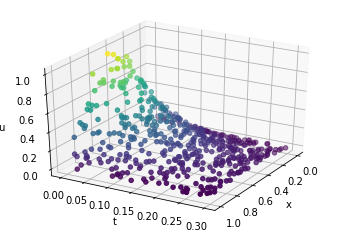

In [15]:
pts = define_random_points(500, False)
u = get_exact_solution(pts)
u = add_relative_noise(u)
scatterplot(pts, u)

Note that we can control the number of these datapoints. In fact part of what we wanna do in this notebook is to measure how the accuracy of our neural network scales with the number of datapoints.
To further illustrate this, here's what the data could look like if we had much less of it.

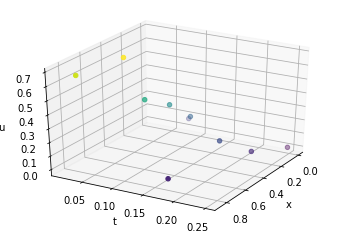

In [16]:
pts = define_random_points(10)
u = get_exact_solution(pts)
u = add_relative_noise(u)
scatterplot(pts, u)

However, this isn't all we have! We effectively get some datapoints for free. In this case we know the boundary conditions. Recall that the initial concentration distribution through the tube is known and we also know that the concentration at each end is always zero.

To reemphasize, if this weren't a contrived experiment, the "datapoints" you see above would have to be measured somehow. Maybe you would need to run a physical system. Or maybe you have a more complicated model on your computer, which is expensive to run and which you want to approximate. Thus, the datapoints would be expensive. On the other hand the points at the boundaries are free*. 

These boundary values will look something like this.

*) Note that when I say "free", I mean virtually free to acquire. Of course training the model on these points is still costly.

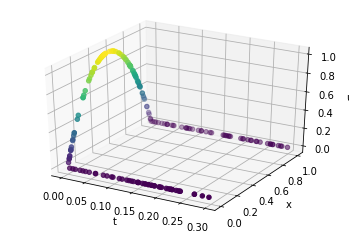

In [17]:
visualize_boundaries(100,100)

## 3. Defining the Neural Networks

Next, I define the function PDE_loss, which for a given model, returns a loss that is smaller the better the model obeys the PDE above.

In [18]:
def first_derivative_time(pts, epsilon=1e-4):
  preceding = pts.clone().detach()
  following = pts.clone().detach()
  preceding[:,0] = preceding[:,0]-epsilon
  following[:,0] = following[:,0]+epsilon
  return (model(following).squeeze()-model(preceding).squeeze() ) / (2*epsilon)

def second_derivative_space(pts,w ,epsilon=1e-3):
  y = []
  preceding = pts.clone().detach()
  following = pts.clone().detach()
  preceding[:,1] = preceding[:,1]-epsilon
  following[:,1] = following[:,1]+epsilon
  y.append(model(preceding).squeeze())
  y.append(w.squeeze())
  y.append(model(following).squeeze())
  return (y[2]-2*y[1]+y[0]) / (epsilon**2)

def PDE_loss(pts,debug=False):
  w    = model(pts)
  w_t  = first_derivative_time(pts)
  w_xx = second_derivative_space(pts,w)
  if debug:
    print('manual w_t[0:5]: ', w_t[0:5])
    print('manual w_xx[0:5]', w_xx[0:5])
  return w_t - w_xx

Finally, we can get to the meat of the matter and define our neural network as well as the loss function that goes with it.

In [19]:
class NN_u(nn.Module):
  def __init__(self):
    super(NN_u, self).__init__()
    self.model = nn.Sequential(
          nn.Linear(2, 20), 
          nn.Tanh(), 
          nn.Linear(20,200),
          nn.Tanh(),
          nn.Linear(200,20), 
          nn.Tanh(),
          nn.Linear(20,1)
    )
  def forward(self,x):
    return self.model(x)

learning_rate = 2e-4

# Loss function receives the boolean boundary_cond, indicating whether to 
# consider boundary conditions, the boolean PDE indicating whether to consider 
# the loss coming from the PDE itself and the boolean measurements indicating 
# whether we have access to measurement data.
def loss(lambda_t, lambda_PDE, lambda_m, boundary_cond=True, b_t=None, b_x=None,
         b_t_val=None, b_x_val=None, PDE=True, measurements=False, m_pts=None, 
         u=None, display_losses=False):

  fits_spatial_boundary = 0
  fits_time_boundary    = 0
  fits_PDE              = 0
  fits_m_pts            = 0

  if boundary_cond:
    u_pred_b_t  = model(b_t.float())
    u_pred_b_t  = u_pred_b_t.squeeze()
    u_pred_b_x  = model(b_x.float())   
    u_pred_b_x  = u_pred_b_x.squeeze()
    fits_spatial_boundary = torch.mean((u_pred_b_x - b_x_val)**2)
    fits_time_boundary    = torch.mean((u_pred_b_t - b_t_val)**2)

  if PDE:
    PDE_pts = define_random_points(1000,True)
    fits_PDE = torch.mean(PDE_loss(PDE_pts)**2)

  if measurements:
    u_pred = model(m_pts)
    u_pred = u_pred.squeeze()
    fits_m_pts = torch.mean((u_pred - u)**2)

  if display_losses:
      print('fits_PDE: ', fits_PDE)
      print('data loss: ',fits_m_pts)
      print('time boundary loss: ', fits_time_boundary)
      print('space boundary loss: ',fits_spatial_boundary)

  return  fits_spatial_boundary \
          + lambda_t * fits_time_boundary \
          + lambda_PDE * fits_PDE \
          + lambda_m   * fits_m_pts  

In [20]:
def train_model(n_updates, boundary_cond=False, PDE=True, measurements=False,
                n_train=0, lambda_t=1, lambda_m=1, lambda_PDE=1e-3, 
                display_losses=False):

  # Even if the argument measurements=True is received, we will set it to zero 
  # if the number of training examples n_train is zero.
  if n_train==0 and measurements:
    raise ValueError('Measurements was set to true, but n_train to zero.')

  if boundary_cond:
    n_b_t, n_b_x = 300, 2*150
    b_t, b_x = define_boundaries(n_b_t, n_b_x)
    b_t_val, b_x_val = get_boundary_values(b_t, b_x)
  else:
    b_t = b_x = b_t_val = b_x_val = None

  if measurements:
    m_pts = define_random_points(n_train)
    u = get_exact_solution(m_pts)
    u = add_relative_noise(u)
  else:
    m_pts = u = None

  def closure():
    optimizer.zero_grad()
    l = loss(lambda_t, lambda_PDE, lambda_m, boundary_cond, b_t, b_x, b_t_val,
             b_x_val, PDE, measurements, m_pts, u)
    l.backward(retain_graph=True)
    return l

  def closure():
    optimizer.zero_grad()
    l = loss(lambda_t, lambda_PDE, lambda_m, boundary_cond, b_t, b_x, b_t_val,
             b_x_val, PDE, measurements, m_pts, u)
    l.backward(retain_graph=True)
    return l

  for i in range(n_updates):
    optimizer.step(closure)
    if (display_losses and i%600 ==0):
      print('*iteration* ', i)
      ls = loss(lambda_t, lambda_PDE, lambda_m, boundary_cond, b_t,b_x, b_t_val,
             b_x_val, PDE, measurements, m_pts, u, display_losses=True)
      print("total loss: ", ls)

Now we have a Neural Network which can learn from datapoints, can take the boundary into account and can be trained by evaluating how well the current model obeys the known PDE. And we can control whether or not to consider each one of those terms. Let's try it by taking all of them into account!

*iteration*  0
fits_PDE:  tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>)
data loss:  tensor(0.0369, device='cuda:0', grad_fn=<MeanBackward0>)
time boundary loss:  tensor(0.3438, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
space boundary loss:  tensor(0.0260, device='cuda:0', grad_fn=<MeanBackward0>)
total loss:  tensor(0.4067, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
*iteration*  600
fits_PDE:  tensor(2.9590, device='cuda:0', grad_fn=<MeanBackward0>)
data loss:  tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>)
time boundary loss:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
space boundary loss:  tensor(0.0232, device='cuda:0', grad_fn=<MeanBackward0>)
total loss:  tensor(0.0668, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
*iteration*  1200
fits_PDE:  tensor(2.3627, device='cuda:0', grad_fn=<MeanBackward0>)
data loss:  tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward0>)
tim

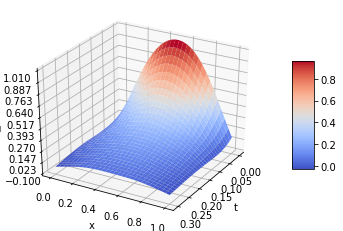

In [21]:
model = NN_u()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_model(1801, True, True, True, 50, display_losses=True)
sketch(30,30,False,30,30)

Looking good!

## 4. Bringing it all together

We have all the necessary pieces together to train a model while controlling what terms go into the loss function and then evaluate the final model. That's what the following function does.

In [22]:
def get_MSE_for_n_samples(n_updates, boundary_cond= True, PDE=True, 
                          measurements=False, n_train=0, display_losses=False):

  n_eval = 300
  
  train_model(n_updates, boundary_cond, PDE, measurements, n_train, 
                display_losses)

  return evaluate_model(n_eval)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we get to the heart of this notebook. The next cell creates, trains and evaluates a certain number (n_runs) of models, each with an increasing number of random datapoints to learn from (stored in m). For every number of random datapoints, we train one Vanilla model, one Vanilla + Boundary model, and one which takes the PDE into account as well.

Each model gets to learn for the same number of gradient updates n_updates. 

Subsequently, we store the final MSE (Mean Squared Error) achieved on the evaluation points with each model in MSEs_Vanilla, MSEs_B, and MSEs_PINN_data; i.e. these are lists containing the MSE obtained during evaluation for different models trained with differing numbers of training points.

In [24]:
# define the number of runs, i.e. number of n_train,
# for each of which we will train and evaluate the model.
n_runs    = 60
n_updates = 2101
factor_btwn_runs = 300**(1/(n_runs-1))

m = np.zeros((n_runs))
for i in range(n_runs):
  m[i] = np.round(1*(factor_btwn_runs**i))
m = m.astype(int)
print(m)

MSEs_Vanilla = []
MSEs_B = []
MSEs_PINN_data = []

for n_train in m:
  print("*** ", n_train, " Datapoints***")
  # 1. Vanilla
  model = NN_u()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  MSE = get_MSE_for_n_samples(n_updates, boundary_cond=False, PDE=False,
                              measurements=True, n_train=n_train)
  MSE = MSE.cpu().detach().numpy()
  MSEs_Vanilla.append(MSE)

  # 2. Vanilla + Boundary
  model = NN_u()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  MSE = get_MSE_for_n_samples(n_updates, boundary_cond=True, PDE=False,
                              measurements=True, n_train=n_train)
  MSE = MSE.cpu().detach().numpy()
  MSEs_B.append(MSE)

  # 3. Full PINN With Data
  model = NN_u()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  MSE = get_MSE_for_n_samples(n_updates, boundary_cond=True, PDE=True,
                              measurements=True, n_train=n_train)
  MSE = MSE.cpu().detach().numpy()
  MSEs_PINN_data.append(MSE)

[  1   1   1   1   1   2   2   2   2   2   3   3   3   4   4   4   5   5
   6   6   7   8   8   9  10  11  12  14  15  17  18  20  22  24  27  29
  32  36  39  43  48  53  58  64  70  78  85  94 104 114 126 138 152 168
 185 204 224 247 272 300]
***  1  Datapoints***
***  1  Datapoints***
***  1  Datapoints***
***  1  Datapoints***
***  1  Datapoints***
***  2  Datapoints***
***  2  Datapoints***
***  2  Datapoints***
***  2  Datapoints***
***  2  Datapoints***
***  3  Datapoints***
***  3  Datapoints***
***  3  Datapoints***
***  4  Datapoints***
***  4  Datapoints***
***  4  Datapoints***
***  5  Datapoints***
***  5  Datapoints***
***  6  Datapoints***
***  6  Datapoints***
***  7  Datapoints***
***  8  Datapoints***
***  8  Datapoints***
***  9  Datapoints***
***  10  Datapoints***
***  11  Datapoints***
***  12  Datapoints***
***  14  Datapoints***
***  15  Datapoints***
***  17  Datapoints***
***  18  Datapoints***
***  20  Datapoints***
***  22  Datapoints***
***  24  Datapoints*

Finally, let's also try to train a few models with access to the PDE and boundary conditions, but no data at all. We're still running multiple ones, so we can take an average at the end.

In [25]:
MSEs_PINN_no_data = []

# 4. Full PINN Without Data 
# Separate for Loop: doesn't scale with number of datapoints.
# Still run multiple times to reduce variance.
for i in range(int(n_runs//2)):
  model = NN_u()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  MSE = get_MSE_for_n_samples(n_updates, boundary_cond=True, PDE=True,
                              measurements=False)
  MSE = MSE.cpu().detach().numpy()
  MSEs_PINN_no_data.append(MSE)
Mean_MSE_PINN_no_data = np.mean(MSEs_PINN_no_data)

Great! Now, let's store the results.

In [26]:
results = {
    'Vanilla': MSEs_Vanilla,
    'Vanilla + Boundary': MSEs_B,
    'Full PINN with Data': MSEs_PINN_data,
}

with open('results_without_data.csv', 'w') as file:
  writer = csv.writer(file)
  writer.writerow(['mean', Mean_MSE_PINN_no_data])

zipped_results = zip(*results.values())
with open('result_with_data_table.csv', 'w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(results.keys())
    writer.writerows(zipped_results)

!cp results_with_data_table.csv /content/drive/MyDrive/Colab\ Notebooks/Playing\ with\ PINNs/5\ -\ Results/
!cp results_without_data.csv /content/drive/MyDrive/Colab\ Notebooks/Playing\ with\ PINNs/5\ -\ Results/

cp: cannot stat 'results_with_data_table.csv': No such file or directory


## 5. Result visualization

Let's plot the results!

I chose to plot this on a log-log graph. This is for two reasons. 

First, it seems most intuitive to me to think of both the error and the number of datapoints in logarithmic terms. For instance, obviously the difference in performance between having access to 2 datapoints and 4 datapoints is expected to be much bigger than the difference between 300 and 302. 

Second, it turns out a power law seems to fit the data reasonably well.

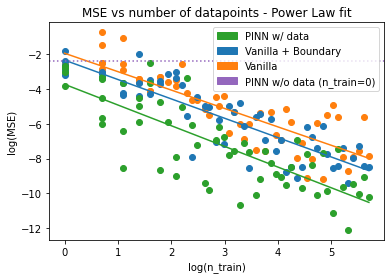

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
log_m = np.log(m)

log_MSEs_Vanilla   = np.log(MSEs_Vanilla)
log_MSEs_B       = np.log(MSEs_B)
log_MSEs_PINN_data = np.log(MSEs_PINN_data)

orange = '#ff7f0e'
blue   = '#1f77b4'
green  = '#2ca02c'
violet = '#9467bd'

ax.scatter(log_m, log_MSEs_Vanilla, c=orange)
ax.scatter(log_m, log_MSEs_B,c=blue)
ax.scatter(log_m, log_MSEs_PINN_data, c=green)

u = np.polyfit(log_m, log_MSEs_Vanilla, 1)
q = np.poly1d(u)
plt.plot(log_m,q(log_m),orange)

v = np.polyfit(log_m, log_MSEs_B, 1)
r = np.poly1d(v)
plt.plot(log_m,r(log_m),blue)

w = np.polyfit(log_m, log_MSEs_PINN_data, 1)
s = np.poly1d(w)
plt.plot(log_m,s(log_m),green)

plt.axhline(y=np.log(Mean_MSE_PINN_no_data), color=violet, linestyle=':')
#plt.show()

ax.set_title("MSE vs number of datapoints - Power Law fit")
plt.ylabel("log(MSE)")
plt.xlabel("log(n_train)")

orange_patch = mpatches.Patch(color='#ff7f0e', label='Vanilla')
blue_patch   = mpatches.Patch(color='#1f77b4', label='Vanilla + Boundary')
green_patch  = mpatches.Patch(color='#2ca02c', label='PINN w/ data')
violet_patch = mpatches.Patch(color=violet, label='PINN w/o data (n_train=0)')

plt.legend(handles=[green_patch, blue_patch, orange_patch, violet_patch])

plt.savefig("test.pdf", dpi=150)
!cp test.pdf /content/drive/MyDrive/Colab\ Notebooks/Playing\ with\ PINNs/5\ -\ Results/

As expected, more data helps. For all models it's clear the MSE gets smaller when the model is trained with more data.

The interesting part is comparing the different curves.

The model with access to boundary conditions perform significantly better for small amounts of training data. That makes sense! Having access to "free" points at the boundary is important when the model has little else to go on. As we feed more data, the difference starts vanishing.

# Conclusion

I think this notebook illustrates well that having access to boundary conditions can help a lot if gathering data is expensive.

# Appendix

To evaluate the model, we use a certain number (n_eval) of random points in the domain. This adds variance to the graph above: what we care about is performance on the whole domain, but we only measure it at a small set of points. 

Here I show that n_eval = 300 is a reasonable choice. 

The evaluation is still reasonably fast while the coefficient of variation between multiple evaluations of the same model (i.e. standard deviation divided by the mean) is below 10% in the example below. That example was chosen to be particularly unfavorable (only one datapoint apart from boundary condition --> relatively bad model --> where we measure makes a bigger difference). 

These 10% stand in contrast to much bigger performance differences between models trained under the same conditions and hence are acceptable.

In [28]:
model = NN_u()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#train and evaluate that model
MSE = get_MSE_for_n_samples(1501, True, False)
MSE = MSE.cpu().detach().numpy()
MSEs_eval = []
MSEs_eval.append(MSE)

In [29]:
for i in range(15):
  MSE = evaluate_model(300).cpu().detach().numpy()
  MSEs_eval.append(MSE)

Coefficient of variation:  0.0740642


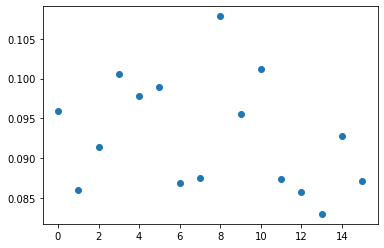

In [30]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(np.arange(0,len(MSEs_eval),1), MSEs_eval)

print("Coefficient of variation: ", np.std(MSEs_eval)/np.mean(MSEs_eval))